# E-classify: This Notebook develops and evaluates the NOIRE-Net E-region classification networks

## 1 - Develop NOIRE-Net

### 1.1 - Import libaries 

In [12]:
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics import mean_squared_error
from math import sqrt
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, f1_score, accuracy_score

### 1.2 - Define function to get ionogram label (True = E-region, False = No E-region)

In [2]:
# The function get_label_from_par reads a .par file and returns 
# True if either the second or fourth item is not 'nan', 
# indicating the presence of an E-region in the corresponding image,
# for use in binary classification.

def get_label_from_par(par_file_path):
    try:
        # Open the .par file located at par_file_path
        with open(par_file_path, 'r') as file:
            content = file.readline().strip()  # Read and strip the first line of the file
            items = content.split()  # Split the line into individual items (usually numbers or 'nan')

            # Check the second (index 1) and fourth (index 3) items:
            # If either of these items is not 'nan', it implies the presence of an E-region.
            # The function then returns True, indicating that this image has an E-region.
            is_e_region = items[1].lower() != 'nan' or items[3].lower() != 'nan'
        return is_e_region

    except IndexError:
        # This block catches an IndexError, which occurs if the line read from the file
        # does not have at least four items. In such a case, the function assumes that
        # the E-region data is not present or not properly formatted, and returns False.
        return False

    except Exception as e:
        # This block catches any other exceptions (like file not found, read errors, etc.).
        # It prints the exception message and returns False, indicating an issue with processing the file.
        print(f"Error reading {par_file_path}: {e}")
        return False

### 1.3 - Define function to load ionograms and preprocess the data

In [3]:
# The load_data function loads and preprocesses image data from a specified directory,
# converting images to grayscale and resizing them, while also extracting corresponding
# binary labels from associated .par files for a classification task.

def load_data(data_dir):
    images = []  # List to store preprocessed images
    labels = []  # List to store corresponding labels

    # Construct paths to the directories containing ionograms and parameters
    ionograms_dir = os.path.join(data_dir, 'ionograms')
    parameters_dir = os.path.join(data_dir, 'parameters')

    # Iterate over the files in the ionograms directory
    for filename in os.listdir(ionograms_dir):
        if filename.endswith('.png'):  # Check if the file is a PNG image
            # Construct full paths to the image file and its corresponding .par file
            img_path = os.path.join(ionograms_dir, filename)
            par_path = os.path.join(parameters_dir, filename.replace('.png', '.par'))

            # Load the image, convert it to grayscale, resize it, and normalize pixel values
            image = load_img(img_path, color_mode='grayscale', target_size=(310, 310))
            image = img_to_array(image)
            image /= 255.0  # Normalize image pixels to be between 0 and 1

            # Load the label for the image using the get_label_from_par function
            label = get_label_from_par(par_path)

            # Append the preprocessed image and label to their respective lists
            images.append(image)
            labels.append(label)

    # Convert the lists of images and labels to numpy arrays and return them
    return np.array(images), np.array(labels).astype(int)

### 1.4 - Load the ionograms and labels from the data folder 

In [4]:
# Specify the directory where the data is stored
data_dir = 'train-val'  # 'train_test_val' should be replaced with the actual path to your data directory

# Call the load_data function to load and preprocess the data
# X wildsdsdl contain the preprocessed images, and y will contain the corresponding labels
X, y = load_data(data_dir)

### 1.5 - Define a function to create the NOIRE-Net architecture

In [5]:
# This code defines and complies NOIRE-Net a convolutional neural network (CNN) model using Keras, 
# with multiple convolutional layers, batch normalization, max pooling, and dense layers, 
# designed for binary classification tasks.

def NOIREnet():
    model = Sequential([
    # First convolutional layer with 32 filters and a kernel size of 3x3
    # 'padding=same' ensures the output size is the same as the input size
    # 'input_shape' is set for the first layer to indicate the shape of the input data
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(310, 310, 1)),
    
    # Batch normalization to normalize the activations from the previous layer
    BatchNormalization(),

    # Second convolutional layer with 32 filters and a kernel size of 3x3
    Conv2D(32, (3, 3), activation='relu'),

    # Another batch normalization
    BatchNormalization(),

    # First max pooling layer to reduce spatial dimensions
    MaxPooling2D((2, 2)),

    # Repeating the pattern of two convolutional layers followed by batch normalization
    # and a max pooling layer, gradually increasing the number of filters
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten the output from the convolutional layers to feed into dense layers
    Flatten(),

    # Dense (fully connected) layer with 256 neurons and relu activation
    Dense(256, activation='relu'),

    # Dropout layer to reduce overfitting
    Dropout(0.5),

    # Another dense layer with 128 neurons
    Dense(128, activation='relu'),

    # Output layer with a single neuron and sigmoid activation for binary classification
    Dense(1, activation='sigmoid')
    ])
    
    # Compile the CNN model
    model.compile(
        optimizer='adam',  # Using the Adam optimizer for adaptive learning rate optimization
        loss='binary_crossentropy',  # Binary crossentropy loss function, suitable for binary classification tasks
        metrics=['accuracy']  # The model will report 'accuracy' as a performance metric
    )
    
    # Return the compiled model
    return model

### 1.6 - Train 10 CNNs for E-region classification and save the models

In [8]:
# This code trains 10 Convolutional Neural Networks (CNNs) on differently split subsets
# of a dataset for binary classification,saves the best model of each training session, 
# and records their training histories.

import os
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Create the directory for saving models and histories if it doesn't exist
save_dir = 'E-classify'
os.makedirs(save_dir, exist_ok=True)

# Initialize lists to store the training histories and filenames of the best models
histories = []
model_filenames = []

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,      # Factor to reduce the learning rate
    patience=10,     # Number of epochs with no improvement to wait before reducing LR
    min_lr=0.00001   # Minimum learning rate
)

# Loop to train 10 CNN models with different data splits
for i in range(10):
    # Split the dataset into training and validation sets with stratification
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=i)
    
    # Create a new CNN model for each iteration
    model = NOIREnet()

    # Define the filename for the checkpoint model
    model_filename = os.path.join(save_dir, f'E-label_run{i+1}.h5')

    # Define a checkpoint callback to save the best model based on validation accuracy
    checkpoint_callback = ModelCheckpoint(
        model_filename,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max',
        save_weights_only=False
    )

    # Train the model with specified callbacks including ReduceLROnPlateau
    history = model.fit(
        X_train, y_train,
        batch_size=64,
        epochs=30,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint_callback, reduce_lr]  # Include ReduceLROnPlateau callback
    )

    # Save the training history and the filename of the saved best model
    histories.append(history.history)
    model_filenames.append(model_filename)

# Optionally, save the training histories to a file in the same 'E-classify' directory
history_filename = os.path.join(save_dir, 'training_histories.pkl')
with open(history_filename, 'wb') as file:
    pickle.dump({'histories': histories, 'model_filenames': model_filenames}, file)


Epoch 1/30


2023-11-28 15:34:35.470280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

144/145 [============================>.] - ETA: 0s - loss: 0.2045 - accuracy: 0.9195

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

145/145 [==============================] - ETA: 0s - loss: 0.2041 - accuracy: 0.9196

2023-11-28 15:35:30.922168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'



Epoch 1: val_accuracy improved from -inf to 0.34370, saving model to E-classify/E-label_run1.h5


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'


145/145 [==============================] - 65s 433ms/step - loss: 0.2041 - accuracy: 0.9196 - val_loss: 3.5268 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 2/30
145/145 [==============================] - ETA: 0s - loss: 0.1115 - accuracy: 0.9617
Epoch 2: val_accuracy did not improve from 0.34370
145/145 [==============================] - 68s 466ms/step - loss: 0.1115 - accuracy: 0.9617 - val_loss: 1.2542 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 3/30
145/145 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 0.9655
Epoch 3: val_accuracy improved from 0.34370 to 0.35363, saving model to E-classify/E-label_run1.h5
145/145 [==============================] - 68s 468ms/step - loss: 0.0965 - accuracy: 0.9655 - val_loss: 2.1787 - val_accuracy: 0.3536 - lr: 0.0010
Epoch 4/30
145/145 [==============================] - ETA: 0s - loss: 0.0878 - accuracy: 0.9696
Epoch 4: val_accuracy improved from 0.35363 to 0.68523, saving model to E-classify/E-label_run1.h5
145/145 [=============

2023-11-28 16:07:50.121372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

144/145 [============================>.] - ETA: 0s - loss: 0.2117 - accuracy: 0.9172

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

145/145 [==============================] - ETA: 0s - loss: 0.2115 - accuracy: 0.9172

2023-11-28 16:09:04.737064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'



Epoch 1: val_accuracy improved from -inf to 0.34370, saving model to E-classify/E-label_run2.h5
145/145 [==============================] - 85s 567ms/step - loss: 0.2115 - accuracy: 0.9172 - val_loss: 2.2256 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 2/30


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'


145/145 [==============================] - ETA: 0s - loss: 0.1109 - accuracy: 0.9611
Epoch 2: val_accuracy did not improve from 0.34370
145/145 [==============================] - 64s 439ms/step - loss: 0.1109 - accuracy: 0.9611 - val_loss: 0.8737 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 3/30
145/145 [==============================] - ETA: 0s - loss: 0.0967 - accuracy: 0.9662
Epoch 3: val_accuracy did not improve from 0.34370
145/145 [==============================] - 64s 441ms/step - loss: 0.0967 - accuracy: 0.9662 - val_loss: 1.5180 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 4/30
145/145 [==============================] - ETA: 0s - loss: 0.0832 - accuracy: 0.9716
Epoch 4: val_accuracy improved from 0.34370 to 0.85190, saving model to E-classify/E-label_run2.h5
145/145 [==============================] - 65s 447ms/step - loss: 0.0832 - accuracy: 0.9716 - val_loss: 0.3646 - val_accuracy: 0.8519 - lr: 0.0010
Epoch 5/30
145/145 [==============================] - ETA: 0s - loss: 0.0746 - ac

2023-11-28 16:40:19.460995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

144/145 [============================>.] - ETA: 0s - loss: 0.2051 - accuracy: 0.9163

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

145/145 [==============================] - ETA: 0s - loss: 0.2047 - accuracy: 0.9166

2023-11-28 16:41:35.888634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'



Epoch 1: val_accuracy improved from -inf to 0.34370, saving model to E-classify/E-label_run3.h5


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'


145/145 [==============================] - 86s 579ms/step - loss: 0.2047 - accuracy: 0.9166 - val_loss: 3.6845 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 2/30
145/145 [==============================] - ETA: 0s - loss: 0.1082 - accuracy: 0.9629
Epoch 2: val_accuracy did not improve from 0.34370
145/145 [==============================] - 84s 579ms/step - loss: 0.1082 - accuracy: 0.9629 - val_loss: 2.7061 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 3/30
145/145 [==============================] - ETA: 0s - loss: 0.0944 - accuracy: 0.9680
Epoch 3: val_accuracy improved from 0.34370 to 0.65674, saving model to E-classify/E-label_run3.h5
145/145 [==============================] - 82s 566ms/step - loss: 0.0944 - accuracy: 0.9680 - val_loss: 1.1042 - val_accuracy: 0.6567 - lr: 0.0010
Epoch 4/30
145/145 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.9678
Epoch 4: val_accuracy improved from 0.65674 to 0.89119, saving model to E-classify/E-label_run3.h5
145/145 [=============

2023-11-28 17:21:09.219796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

144/145 [============================>.] - ETA: 0s - loss: 0.2036 - accuracy: 0.9218

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

145/145 [==============================] - ETA: 0s - loss: 0.2033 - accuracy: 0.9217

2023-11-28 17:22:04.099841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'



Epoch 1: val_accuracy improved from -inf to 0.34370, saving model to E-classify/E-label_run4.h5
145/145 [==============================] - 67s 433ms/step - loss: 0.2033 - accuracy: 0.9217 - val_loss: 2.7644 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 2/30


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'


145/145 [==============================] - ETA: 0s - loss: 0.1180 - accuracy: 0.9603
Epoch 2: val_accuracy did not improve from 0.34370
145/145 [==============================] - 67s 458ms/step - loss: 0.1180 - accuracy: 0.9603 - val_loss: 2.1823 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 3/30
145/145 [==============================] - ETA: 0s - loss: 0.0985 - accuracy: 0.9634
Epoch 3: val_accuracy improved from 0.34370 to 0.40112, saving model to E-classify/E-label_run4.h5
145/145 [==============================] - 67s 459ms/step - loss: 0.0985 - accuracy: 0.9634 - val_loss: 1.5528 - val_accuracy: 0.4011 - lr: 0.0010
Epoch 4/30
145/145 [==============================] - ETA: 0s - loss: 0.0923 - accuracy: 0.9634
Epoch 4: val_accuracy improved from 0.40112 to 0.88731, saving model to E-classify/E-label_run4.h5
145/145 [==============================] - 67s 460ms/step - loss: 0.0923 - accuracy: 0.9634 - val_loss: 0.3069 - val_accuracy: 0.8873 - lr: 0.0010
Epoch 5/30
145/145 [=============

2023-11-28 17:54:18.969576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

144/145 [============================>.] - ETA: 0s - loss: 0.2039 - accuracy: 0.9255

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

145/145 [==============================] - ETA: 0s - loss: 0.2033 - accuracy: 0.9255

2023-11-28 17:55:32.502644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'



Epoch 1: val_accuracy improved from -inf to 0.34370, saving model to E-classify/E-label_run5.h5
145/145 [==============================] - 84s 552ms/step - loss: 0.2033 - accuracy: 0.9255 - val_loss: 4.4203 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 2/30


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'


145/145 [==============================] - ETA: 0s - loss: 0.1166 - accuracy: 0.9595
Epoch 2: val_accuracy did not improve from 0.34370
145/145 [==============================] - 80s 549ms/step - loss: 0.1166 - accuracy: 0.9595 - val_loss: 3.5444 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 3/30
145/145 [==============================] - ETA: 0s - loss: 0.1021 - accuracy: 0.9626
Epoch 3: val_accuracy did not improve from 0.34370
145/145 [==============================] - 82s 566ms/step - loss: 0.1021 - accuracy: 0.9626 - val_loss: 2.3180 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 4/30
145/145 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9687
Epoch 4: val_accuracy improved from 0.34370 to 0.65630, saving model to E-classify/E-label_run5.h5
145/145 [==============================] - 83s 569ms/step - loss: 0.0924 - accuracy: 0.9687 - val_loss: 1.5085 - val_accuracy: 0.6563 - lr: 0.0010
Epoch 5/30
145/145 [==============================] - ETA: 0s - loss: 0.0849 - ac

2023-11-28 18:34:31.734281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

144/145 [============================>.] - ETA: 0s - loss: 0.2204 - accuracy: 0.9124

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

145/145 [==============================] - ETA: 0s - loss: 0.2201 - accuracy: 0.9125

2023-11-28 18:35:23.117228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'



Epoch 1: val_accuracy improved from -inf to 0.34370, saving model to E-classify/E-label_run6.h5
145/145 [==============================] - 64s 407ms/step - loss: 0.2201 - accuracy: 0.9125 - val_loss: 2.7409 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 2/30


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'


145/145 [==============================] - ETA: 0s - loss: 0.1229 - accuracy: 0.9584
Epoch 2: val_accuracy did not improve from 0.34370
145/145 [==============================] - 66s 453ms/step - loss: 0.1229 - accuracy: 0.9584 - val_loss: 2.2283 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 3/30
145/145 [==============================] - ETA: 0s - loss: 0.0985 - accuracy: 0.9640
Epoch 3: val_accuracy improved from 0.34370 to 0.45639, saving model to E-classify/E-label_run6.h5
145/145 [==============================] - 67s 460ms/step - loss: 0.0985 - accuracy: 0.9640 - val_loss: 0.7528 - val_accuracy: 0.4564 - lr: 0.0010
Epoch 4/30
145/145 [==============================] - ETA: 0s - loss: 0.0951 - accuracy: 0.9670
Epoch 4: val_accuracy improved from 0.45639 to 0.91321, saving model to E-classify/E-label_run6.h5
145/145 [==============================] - 66s 457ms/step - loss: 0.0951 - accuracy: 0.9670 - val_loss: 0.3425 - val_accuracy: 0.9132 - lr: 0.0010
Epoch 5/30
145/145 [=============

2023-11-28 19:07:25.996859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

144/145 [============================>.] - ETA: 0s - loss: 0.2085 - accuracy: 0.9179

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

145/145 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.9182

2023-11-28 19:08:39.497240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'



Epoch 1: val_accuracy improved from -inf to 0.34370, saving model to E-classify/E-label_run7.h5


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'


145/145 [==============================] - 84s 553ms/step - loss: 0.2077 - accuracy: 0.9182 - val_loss: 2.3655 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 2/30
145/145 [==============================] - ETA: 0s - loss: 0.1111 - accuracy: 0.9624
Epoch 2: val_accuracy did not improve from 0.34370
145/145 [==============================] - 80s 550ms/step - loss: 0.1111 - accuracy: 0.9624 - val_loss: 2.1657 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 3/30
145/145 [==============================] - ETA: 0s - loss: 0.0939 - accuracy: 0.9686
Epoch 3: val_accuracy improved from 0.34370 to 0.43610, saving model to E-classify/E-label_run7.h5
145/145 [==============================] - 81s 561ms/step - loss: 0.0939 - accuracy: 0.9686 - val_loss: 0.8904 - val_accuracy: 0.4361 - lr: 0.0010
Epoch 4/30
145/145 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9696
Epoch 4: val_accuracy improved from 0.43610 to 0.90846, saving model to E-classify/E-label_run7.h5
145/145 [=============

2023-11-28 19:47:20.229222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

144/145 [============================>.] - ETA: 0s - loss: 0.2050 - accuracy: 0.9182

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

145/145 [==============================] - ETA: 0s - loss: 0.2046 - accuracy: 0.9184

2023-11-28 19:48:15.940457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'



Epoch 1: val_accuracy improved from -inf to 0.34370, saving model to E-classify/E-label_run8.h5


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'


145/145 [==============================] - 69s 439ms/step - loss: 0.2046 - accuracy: 0.9184 - val_loss: 3.8275 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 2/30
145/145 [==============================] - ETA: 0s - loss: 0.1141 - accuracy: 0.9596
Epoch 2: val_accuracy did not improve from 0.34370
145/145 [==============================] - 66s 455ms/step - loss: 0.1141 - accuracy: 0.9596 - val_loss: 3.0667 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 3/30
145/145 [==============================] - ETA: 0s - loss: 0.0972 - accuracy: 0.9640
Epoch 3: val_accuracy did not improve from 0.34370
145/145 [==============================] - 68s 468ms/step - loss: 0.0972 - accuracy: 0.9640 - val_loss: 3.6116 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 4/30
145/145 [==============================] - ETA: 0s - loss: 0.0904 - accuracy: 0.9681
Epoch 4: val_accuracy improved from 0.34370 to 0.90415, saving model to E-classify/E-label_run8.h5
145/145 [==============================] - 65s 450ms/step - loss: 0.09

2023-11-28 20:20:15.668109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

144/145 [============================>.] - ETA: 0s - loss: 0.1966 - accuracy: 0.9244

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

145/145 [==============================] - ETA: 0s - loss: 0.1961 - accuracy: 0.9245

2023-11-28 20:21:32.144185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'



Epoch 1: val_accuracy improved from -inf to 0.34370, saving model to E-classify/E-label_run9.h5


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'


145/145 [==============================] - 87s 572ms/step - loss: 0.1961 - accuracy: 0.9245 - val_loss: 2.0380 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 2/30
145/145 [==============================] - ETA: 0s - loss: 0.1134 - accuracy: 0.9613
Epoch 2: val_accuracy did not improve from 0.34370
145/145 [==============================] - 83s 569ms/step - loss: 0.1134 - accuracy: 0.9613 - val_loss: 1.6481 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 3/30
145/145 [==============================] - ETA: 0s - loss: 0.0943 - accuracy: 0.9680
Epoch 3: val_accuracy improved from 0.34370 to 0.36701, saving model to E-classify/E-label_run9.h5
145/145 [==============================] - 81s 558ms/step - loss: 0.0943 - accuracy: 0.9680 - val_loss: 1.5415 - val_accuracy: 0.3670 - lr: 0.0010
Epoch 4/30
145/145 [==============================] - ETA: 0s - loss: 0.0849 - accuracy: 0.9705
Epoch 4: val_accuracy improved from 0.36701 to 0.89162, saving model to E-classify/E-label_run9.h5
145/145 [=============

2023-11-28 21:01:42.255248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

144/145 [============================>.] - ETA: 0s - loss: 0.2086 - accuracy: 0.9196

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x46x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

145/145 [==============================] - ETA: 0s - loss: 0.2078 - accuracy: 0.9200

2023-11-28 21:02:36.296044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'



Epoch 1: val_accuracy improved from -inf to 0.34370, saving model to E-classify/E-label_run10.h5


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x12x1x1xi1>'


145/145 [==============================] - 68s 422ms/step - loss: 0.2078 - accuracy: 0.9200 - val_loss: 3.0098 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 2/30
145/145 [==============================] - ETA: 0s - loss: 0.1098 - accuracy: 0.9606
Epoch 2: val_accuracy did not improve from 0.34370
145/145 [==============================] - 67s 462ms/step - loss: 0.1098 - accuracy: 0.9606 - val_loss: 1.5537 - val_accuracy: 0.3437 - lr: 0.0010
Epoch 3/30
145/145 [==============================] - ETA: 0s - loss: 0.0894 - accuracy: 0.9687
Epoch 3: val_accuracy improved from 0.34370 to 0.34456, saving model to E-classify/E-label_run10.h5
145/145 [==============================] - 66s 457ms/step - loss: 0.0894 - accuracy: 0.9687 - val_loss: 1.8711 - val_accuracy: 0.3446 - lr: 0.0010
Epoch 4/30
145/145 [==============================] - ETA: 0s - loss: 0.0874 - accuracy: 0.9692
Epoch 4: val_accuracy improved from 0.34456 to 0.82988, saving model to E-classify/E-label_run10.h5
145/145 [===========

## 2 - Test the performance of NOIRE-Net on an independent test set

### 2.1 - Define a function to get ionogram labels from the testing data 

In [13]:
# This code defines the get_majority_label function which determines the majority label 
# (True or False) among a list of .par files, and in case of a tie, it randomly selects a label.
def get_majority_label(par_files):
    # Extract labels from each .par file using the get_label_from_par function
    labels = [get_label_from_par(f) for f in par_files]

    # If the majority of labels are True, return True
    if labels.count(True) > len(labels) / 2:
        return True
    # If the majority of labels are False, return False
    elif labels.count(False) > len(labels) / 2:
        return False
    # If there is a tie between True and False labels, randomly choose one
    else:
        return random.choice([True, False])  # Randomize in case of a tie

### 2.2 - Define a function to load and process test images

In [14]:
# This code defines the load_and_preprocess_image function, which loads an image from a 
# specified path, converts it to grayscale, resizes it to 310x310 pixels, normalizes its pixel
# values, and returns the processed image as an array.
def load_and_preprocess_image(image_path):
    # Load the image from the given path, convert it to grayscale, and resize it to 310x310 pixels
    image = load_img(image_path, color_mode='grayscale', target_size=(310, 310))

    # Convert the image to a numpy array
    image = img_to_array(image)

    # Normalize the pixel values to be in the range [0, 1]
    image /= 255.0

    # Return the preprocessed image
    return image

### 2.3 - Load the trained models with the highest validation accuracy 

In [15]:
# Define function to load models
def load_models(models_dir):
    return [load_model(os.path.join(models_dir, mf)) for mf in os.listdir(models_dir) if mf.endswith('.h5')]

# Specify the directory where the trained models are stored
models_dir = 'E-classify'

# Load the models
models = load_models(models_dir)

### 2.4 - Define a function to prepare the resting data for comparison with CNNs

In [16]:
# This function prepares the testing dataset by loading and processing images from a 
# specified directory and determining corresponding human labels based on majority voting
# from associated .par files.
def prepare_test_data(ionograms_dir, parameters_dir):
    X_test = []  # List to store preprocessed images
    y_human = []  # List to store corresponding human labels

    # Cache the paths of all .par files for efficient access
    par_files_cache = {f: os.path.join(parameters_dir, f) for f in os.listdir(parameters_dir)}

    # Iterate through each image file in the ionograms directory
    for img_file in os.listdir(ionograms_dir):
        if img_file.endswith('.png'):  # Only process .png files
            img_path = os.path.join(ionograms_dir, img_file)
            X_test.append(load_and_preprocess_image(img_path))  # Load and preprocess the image

            # Extract timestamp from the image filename
            timestamp = os.path.splitext(img_file)[0]

            # Get all .par files relevant to the current image based on timestamp
            relevant_par_files = [fpath for fname, fpath in par_files_cache.items() if timestamp in fname]
            y_human.append(get_majority_label(relevant_par_files))  # Determine the majority label

    # Convert lists to numpy arrays
    return np.array(X_test), np.array(y_human).astype(int)

### 2.5 - Define a function compare the CNN predictions to the human labeling

In [17]:
# This function evaluates a list of pre-loaded CNN models on a prepared test dataset, calculates key
# performance metrics (precision, recall, F1-score, accuracy), prints their mean and standard deviation,
# and returns the normalized confusion matrices for each model.
def evaluate_models(models, X_test, y_human):
    metrics = {'precision': [], 'recall': [], 'f1': [], 'accuracy': []}  # Dictionary to store metrics for each model
    confusion_matrices = []  # List to store confusion matrices for each model

    # Iterate over each model and evaluate it
    for model in models:
        y_pred = model.predict(X_test).round().astype(int)  # Predict labels for the test dataset

        # Calculate and store the performance metrics for the current model
        metrics['precision'].append(precision_score(y_human, y_pred))
        metrics['recall'].append(recall_score(y_human, y_pred))
        metrics['f1'].append(f1_score(y_human, y_pred))
        metrics['accuracy'].append(accuracy_score(y_human, y_pred))

        # Calculate and store the normalized confusion matrix
        confusion_matrices.append(confusion_matrix(y_human, y_pred, normalize='true'))

    # Print the mean and standard deviation for each metric
    for metric, values in metrics.items():
        print(f"Mean {metric.capitalize()}: {np.mean(values):.3f}, Std {metric.capitalize()}: {np.std(values):.3f}")

    return confusion_matrices

### 2.6 - Specify testing directories and prepare testing data

In [18]:
# Specify the directory where the testing data is located
testing_dir = 'testing'

# Specify the directory where the input ionograms are located
ionograms_dir = os.path.join(testing_dir, 'ionograms')

# Specify the directory where the output parameters are located
parameters_dir = os.path.join(testing_dir, 'parameters')

# Load and prepare the testing data
X_test, y_human = prepare_test_data(ionograms_dir, parameters_dir)

### 2.7 - Evaluate the models using precision, recall, F1-score, accuracy

In [19]:
# Evaluate the models located in 'models_dir' using the test data in 'testing_dir'
# and store the returned confusion matrices
confusion_matrices = evaluate_models(models, X_test, y_human)

2023-11-28 21:37:43.807279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 55ms/step


2023-11-28 21:37:45.605317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 49ms/step


2023-11-28 21:37:47.072943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 47ms/step


2023-11-28 21:37:48.505406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 47ms/step


2023-11-28 21:37:49.963227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 49ms/step


2023-11-28 21:37:51.420933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 53ms/step


2023-11-28 21:37:53.070000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 53ms/step


2023-11-28 21:37:54.781818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 54ms/step


2023-11-28 21:37:56.554193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 50ms/step


2023-11-28 21:37:58.111046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 54ms/step
Mean Precision: 0.969, Std Precision: 0.007
Mean Recall: 0.971, Std Recall: 0.010
Mean F1: 0.969, Std F1: 0.004
Mean Accuracy: 0.960, Std Accuracy: 0.005


### 2.8 - Calculate the mean and standard deviation of TP, FN, FP and TN

In [20]:
# Convert list of confusion matrices to a 3D NumPy array for easier calculations
confusion_matrices = np.array(confusion_matrices)

# Calculate mean and standard deviation for TP, FN, FP, TN
mean_tp = np.mean(confusion_matrices[:, 1, 1])
std_tp = np.std(confusion_matrices[:, 1, 1])

mean_fn = np.mean(confusion_matrices[:, 1, 0])
std_fn = np.std(confusion_matrices[:, 1, 0])

mean_fp = np.mean(confusion_matrices[:, 0, 1])
std_fp = np.std(confusion_matrices[:, 0, 1])

mean_tn = np.mean(confusion_matrices[:, 0, 0])
std_tn = np.std(confusion_matrices[:, 0, 0])

# Metrics, means, and standard deviations
means = [mean_tp, mean_fn, mean_fp, mean_tn]
std_devs = [std_tp, std_fn, std_fp, std_tn]

## 3 - Display the confusion matrix 

### 3.1 - Define Function for Text Color Based on Background

In [21]:
# This function determines the text color (black or white) based on the background color's
# luminance for better readability.
def text_color_based_on_bg(bg_color):
    # Calculate the perceptual luminance of the color
    luminance = (0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2])
    return 'white' if luminance < 0.5 else 'black'

### 3.2 - Plot the Confusion Matrix Statistics

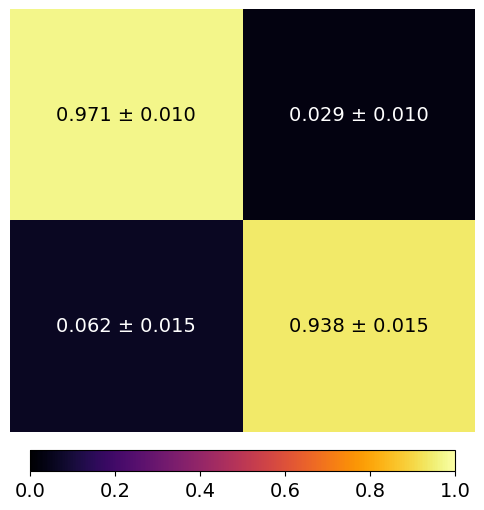

In [22]:
# This code creates a 2x2 plot with colored squares representing the mean and standard 
# deviation of TP, FN, FP, and TN from the confusion matrices.

# Setup color map with normalization between 0 and 1
cmap = plt.cm.inferno
norm = mcolors.Normalize(vmin=0, vmax=1)

# Create a 2x2 subplot figure with adjusted spacing
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs = axs.flatten()

means = [mean_tp, mean_fn, mean_fp, mean_tn]
std_devs = [std_tp, std_fn, std_fp, std_tn]

# Iterate over each subplot to add the confusion matrix data
for i, ax in enumerate(axs):
    color = cmap(norm(means[i]))  # Set the color based on the mean value
    ax.add_patch(plt.Rectangle((0, 0), 1, 1, color=color))  # Create a colored square

    text_color = text_color_based_on_bg(color)  # Determine text color
    text = f'{means[i]:.3f} ± {std_devs[i]:.3f}'  # Format text for mean ± std deviation
    ax.text(0.5, 0.5, text, ha='center', va='center', fontsize=14, color=text_color)  # Add text to the subplot

    ax.axis('off')  # Remove axes

# Adjust subplot parameters so squares touch each other
plt.subplots_adjust(wspace=0, hspace=0)

# Add a colorbar and adjust its font size
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axs, orientation='horizontal', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=14)  # Set font size for colorbar ticks

plt.show()